In [ ]:
pip install numpy pandas matplotlib scikit-learn statsmodels yfinance

In [ ]:
pip install mplfinance

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings

In [2]:
ticker_symbol = "CL=F"  # Ticker symbol for WTI crude oil futures is "CL-F", 
#le ticker "CL=F" (ou parfois écrit "CL-F") correspond au contrat future WTI (West Texas Intermediate) le plus proche, donc généralement le future du mois le plus proche à l’échéance (le « front month »).
start_date = "2022-01-01"
end_date = "2022-12-31"

# Téléchargement des données
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Affichage des 5 premières lignes
print(wti_data.head(5))

# Taille de l'objet (nombre de lignes et de colonnes)
print("Taille de l'objet :", wti_data.shape)

# Type de l'objet
print("Type de l'objet :", type(wti_data))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open  Volume
Ticker           CL=F       CL=F       CL=F       CL=F    CL=F
Date                                                          
2022-01-03  76.080002  76.459999  74.269997  75.690002  317628
2022-01-04  76.989998  77.639999  75.699997  76.019997  372848
2022-01-05  77.849998  78.580002  76.510002  77.180000  397898
2022-01-06  79.459999  80.239998  76.730003  77.239998  476665
2022-01-07  78.900002  80.470001  78.519997  79.620003  414434
Taille de l'objet : (251, 5)
Type de l'objet : <class 'pandas.core.frame.DataFrame'>


In [33]:
# Check for missing values
print(wti_data.isnull().sum(), wti_data.dtypes)
# Get a summary of the data
print(wti_data.describe())

Price   Ticker
Close   CL=F      0
High    CL=F      0
Low     CL=F      0
Open    CL=F      0
Volume  CL=F      0
dtype: int64 Price   Ticker
Close   CL=F      float64
High    CL=F      float64
Low     CL=F      float64
Open    CL=F      float64
Volume  CL=F        int64
dtype: object
Price        Close        High         Low        Open         Volume
Ticker        CL=F        CL=F        CL=F        CL=F           CL=F
count   251.000000  251.000000  251.000000  251.000000     251.000000
mean     94.331474   96.609562   92.034382   94.375339  322828.494024
std      12.392960   12.936314   11.770656   12.468534  120562.642963
min      71.019997   72.919998   70.080002   71.790001   58714.000000
25%      85.570000   87.050003   83.509998   85.244999  271209.000000
50%      91.930000   93.739998   90.349998   91.750000  320304.000000
75%     104.230000  106.610001  101.285000  103.994999  379503.000000
max     123.699997  130.500000  120.790001  124.660004  872244.000000


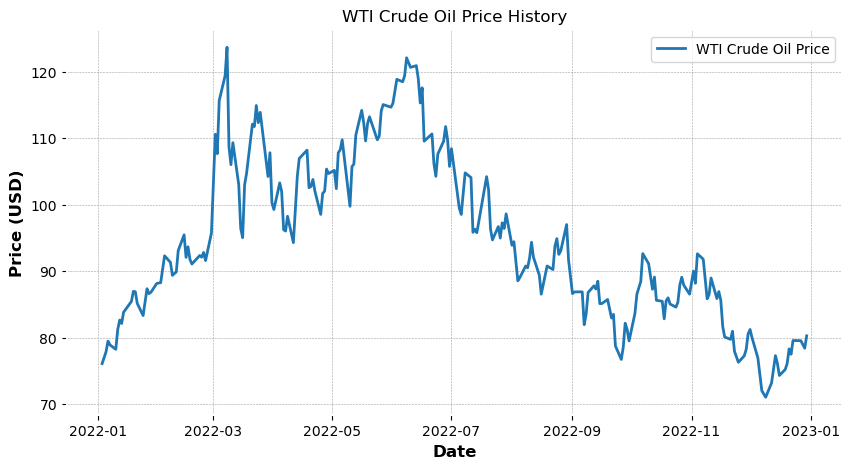

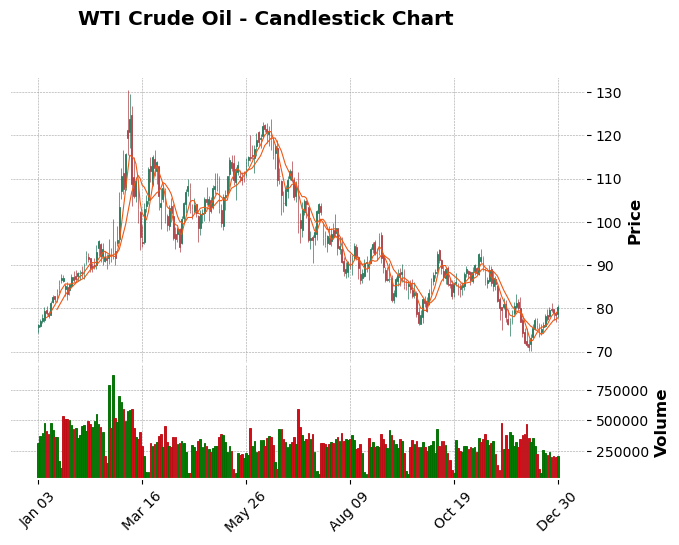

In [44]:
##Plot classique
plt.figure(figsize=(10, 5))
plt.plot(wti_data['Close'], label='WTI Crude Oil Price')
plt.title('WTI Crude Oil Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

##Plot candlestick avec la bibliotheque mplfinance qui permet de créer facilement des graphiques boursiers professionnels,
# S'assurer que l'index est de type datetime (normalement c'est le cas avec yfinance)
wti_data.index = pd.to_datetime(wti_data.index)

wti_data.columns = wti_data.columns.get_level_values(0) #Aplatir les colonnes s'il y a un multi-index

#Graphe Chandelles
mpf.plot(wti_data, type='candle', style='charles', volume=True, title='WTI Crude Oil - Candlestick Chart', mav=(5,10))


## Step 4: Feature Engineering

Pour la prévision de séries temporelles, nous pouvons créer des **features** qui aideront notre modèle à faire de meilleures prédictions :

1. **Créer des lag features** :  
   Une lag feature est une valeur passée de la série temporelle.  
   Par exemple, le prix de la veille peut être un bon prédicteur du prix d’aujourd’hui.

2. **Créer des rolling window features** :  
   Les rolling window features, comme la moyenne mobile, permettent d’atténuer les fluctuations à court terme  
   et d’identifier les tendances à plus long terme.


# Créer des lag features :  
**Pourquoi la méthode des lags est surtout adaptée au court terme ?**

- Les lags utilisent uniquement les valeurs passées proches  
  (ex : prix d’hier, de la semaine dernière, du mois dernier)  
  pour prédire le prix du lendemain.

- Cela fonctionne bien pour des horizons courts, car les prix sont souvent **autocorrélés à court terme** :  
  aujourd’hui dépend fortement d’hier, etc.

- **Mais sur le moyen ou long terme, les dynamiques changent :**  
  - Nouveaux facteurs externes entrent en jeu (politiques, économiques, géopolitiques).  
  - Les tendances peuvent s’inverser.  
  - Les influences non linéaires et complexes sont plus marquées.

---

## Limitations pour les prédictions à plus long terme

- La méthode des lags ne capture pas ces facteurs exogènes et dynamiques complexes.  
- Elle est surtout une bonne base statistique mais **pas un modèle complet pour le forecasting**.

---

## Pour aller au-delà du court terme, on peut :

- Ajouter des variables exogènes  
  (ex : indices économiques, production, stocks, événements).  

- Utiliser des modèles plus complexes  
  (ARIMA, modèles à états, LSTM, réseaux neuronaux).  

- Mettre en place des modèles hybrides combinant données historiques et externes.

[*********************100%***********************]  1 of 1 completed

R² score: 0.9312787264750768
RMSE: 1.6963999061755761



c:\Users\ekhar\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


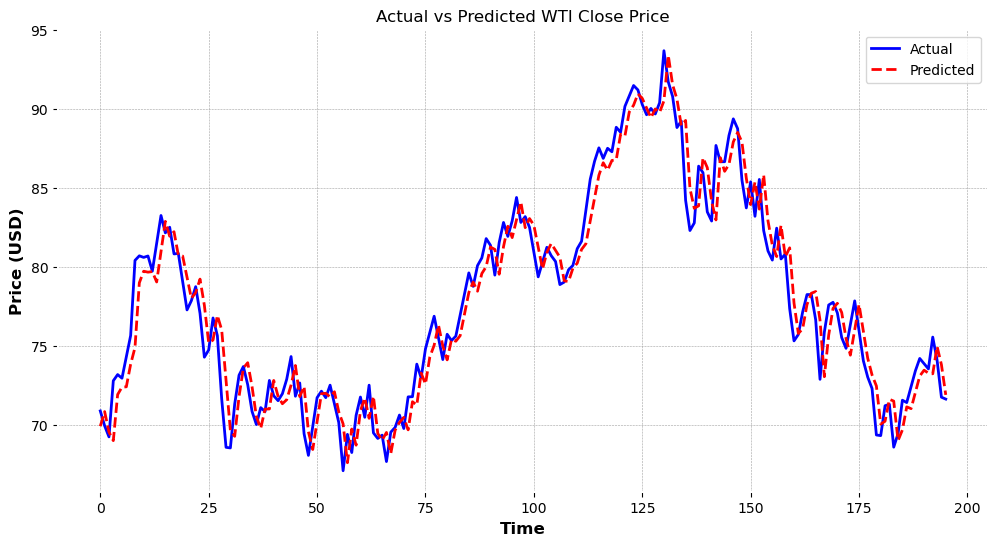

In [62]:
#Le code essaie de prédire le prix de clôture du jour J (Close) en se basant sur :

#Le prix de clôture du jour J-1 (Lag_1)

#Le prix de clôture du jour J-7 (Lag_7)

#Le prix de clôture du jour J-30 (Lag_30)



# Download data
wti_data = yf.download("CL=F", start="2020-01-01", end="2023-12-31")

# Create lag features
wti_data['Lag_1'] = wti_data['Close'].shift(1)
wti_data['Lag_7'] = wti_data['Close'].shift(7)
wti_data['Lag_30'] = wti_data['Close'].shift(30)

# Drop rows with missing values
wti_data.dropna(inplace=True)

# Features and target
X = wti_data[['Lag_1', 'Lag_7', 'Lag_30']]
#print(X)
y = wti_data['Close']

# Train/test split (no shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("R² score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted WTI Close Price')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

R² volatile period: 0.7601486018160046
RMSE volatile period: 4.985031316562923


c:\Users\ekhar\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


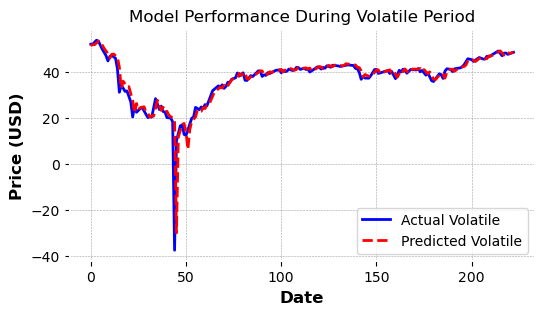

In [69]:
#Bon résultat mais modèle linéaire simple : pas garanti que ça capture tous les phénomènes complexes (volatilité extrême, événements soudains, etc.)
#donc test en période de forte volatilité

# Tester sur 2020 (forte volatilité COVID)
volatile_period = (wti_data.index >= '2020-01-01') & (wti_data.index <= '2020-12-31')

X_volatile = X[volatile_period]
y_volatile = y[volatile_period]

y_volatile_pred = model.predict(X_volatile)

print("R² volatile period:", r2_score(y_volatile, y_volatile_pred))
print("RMSE volatile period:", mean_squared_error(y_volatile, y_volatile_pred, squared=False))

import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.plot(y_volatile.values, label='Actual Volatile', color='blue')
plt.plot(y_volatile_pred, label='Predicted Volatile', color='red', linestyle='--')
plt.title('Model Performance During Volatile Period')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


#Résultats de prédiction moins bon car pendant les phases volatiles, le prix évolue souvent brusquement sous l’effet d’événements imprévus (crises, annonces, chocs externes).
#Un modèle linéaire simple, basé uniquement sur les prix passés, n’est pas capable de capturer ces mouvements rapides et non linéaires.
#Il manque probablement des facteurs explicatifs externes (comme des indicateurs macroéconomiques, géopolitiques, sentiment de marché, etc.).

In [ ]:
#Prédiction du prix du WTI pour demain
latest_date = wti_data.index.max()
print(latest_date)

date_7 = latest_date - pd.Timedelta(days=6)
date_7 = wti_data.index.asof(date_7)

date_30 = latest_date - pd.Timedelta(days=29)
date_30 = wti_data.index.asof(date_30)

lag_1_for_tomorrow = wti_data.loc[latest_date, 'Close']
lag_7_for_tomorrow = wti_data.loc[date_7, 'Close']
lag_30_for_tomorrow = wti_data.loc[date_30, 'Close']

X_tomorrow = pd.DataFrame({
    'Lag_1': [lag_1_for_tomorrow],
    'Lag_7': [lag_7_for_tomorrow],
    'Lag_30': [lag_30_for_tomorrow]
})

predicted_price_tomorrow = model.predict(X_tomorrow).item()
print(f"Prix WTI prédit pour demain : {predicted_price_tomorrow:.2f} USD")


2025-05-30 00:00:00
Prix WTI prédit pour demain : 61.00 USD


c:\Users\ekhar\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\ekhar\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:751: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)


# Create Rolling Window Features:

Rolling window features, like a moving average, can help smooth out short-term fluctuations and identify longer-term trends. We also try to remove the 'LAG-1' from features to see if the model is capable of predicting accurately the price of WTI in 7 days.


[*********************100%***********************]  1 of 1 completed

R² score: 0.7691841955304675
RMSE: 2.7741690763107787



c:\Users\ekhar\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


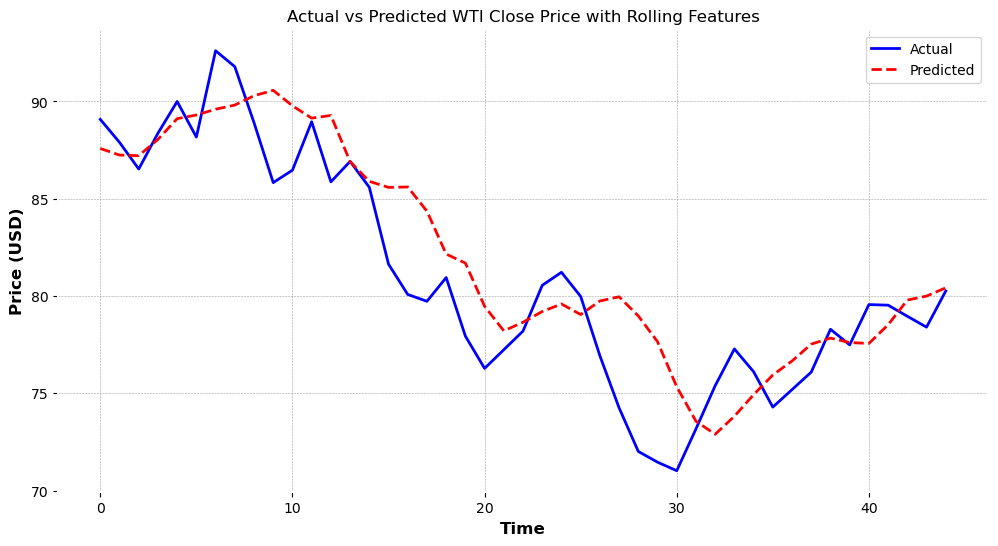

In [92]:
ticker_symbol = "CL=F"
start_date = "2022-01-01"
end_date = "2022-12-31"

# Téléchargement des données
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Create rolling window features
wti_data['Rolling_Mean_7'] = wti_data['Close'].rolling(window=7).mean()
wti_data['Rolling_Std_7'] = wti_data['Close'].rolling(window=7).std()
#wti_data['Lag_1'] = wti_data['Close'].shift(1)
wti_data['Lag_7'] = wti_data['Close'].shift(7)
wti_data['Lag_30'] = wti_data['Close'].shift(30)

# Drop rows with missing values created by the rolling window and lags
wti_data.dropna(inplace=True)

# Prepare features including rolling window features along with lags
X = wti_data[['Lag_7', 'Lag_30', 'Rolling_Mean_7', 'Rolling_Std_7']]
y = wti_data['Close']


# Train-test split (time series split: no shuffling)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate performance
print("R² score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted WTI Close Price with Rolling Features')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

## 🧪 Optimisation des Lags et de la Fenêtre Glissante pour la Prédiction du WTI

### 🎯 Objectif
Optimiser les variables explicatives utilisées dans un modèle de régression linéaire pour prédire le prix du baril de pétrole WTI, en testant différentes combinaisons de :

- **Lags** (décalages temporels) : valeurs passées du prix (ex: J-1, J-3, etc.)
- **Fenêtres glissantes (rolling windows)** : statistiques mobiles comme la moyenne et l’écart-type

---

### ⚙️ Méthodologie

1. **Données** : Prix journalier du WTI (futures CL=F) pour l'année 2022.
2. **Pré-traitement** :
   - Création automatique de différentes combinaisons de lags (parmi 1, 3, 7, 14, 30)
   - Application de fenêtres mobiles de tailles 3, 5, 7, 10 jours
   - Suppression des lignes contenant des valeurs manquantes après le calcul des indicateurs
3. **Modèle** : Régression linéaire (`LinearRegression` de scikit-learn)
4. **Évaluation** : Score R² et RMSE sur un jeu de test (20% des données, sans mélange)

---

### ✅ Résultat Optimal

- **Meilleur score R²** : `0.9599`
- **Lags sélectionnés** : `1, 3, 14`
- **Fenêtre glissante optimale** : `3 jours`

---

### 🔍 Interprétation

- Un **R² de 0.9599** signifie que le modèle explique **95.99%** de la variance du prix du WTI.
- Les **lags 1, 3, 14** montrent une forte autocorrélation à court terme (jusqu'à deux semaines).
- Une **moyenne glissante sur 3 jours** suffit à capter les tendances pertinentes sans trop lisser les fluctuations.

---

### 📌 Prochaines pistes d'amélioration

- Tester des **modèles non linéaires** (Random Forest, XGBoost, etc.)
- Ajouter des **variables exogènes** : cours du Brent, indice dollar, taux d’intérêt, géopolitique...
- Créer des **features techniques** : RSI, momentum, MACD, différenciation, etc.
- Étendre à une **prédiction multi-jour** (ex: T+7)

---

### 📈 Conclusion

Ce modèle de base utilisant des lags et des moyennes mobiles est **très efficace à court terme**. Il constitue un excellent point de départ avant d'explorer des approches plus avancées.


In [6]:
#Ce code teste chaque combinaison de 3 lags parmi une liste et une seule fenêtre roulante (rolling window) à la fois.

ticker_symbol = "CL=F"
start_date = "2022-01-01"
end_date = "2022-12-31"

# Téléchargement des données
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Hyperparamètres à tester
lags_to_test = [1, 3, 7, 14, 30]
rolling_windows_to_test = [3, 5, 7, 14, 30]

best_score = -np.inf
best_params = None

for lag_combo in itertools.combinations(lags_to_test, 3):  # exemple: 3 lags à choisir
    for roll_win in rolling_windows_to_test:
        # Copie des données originales
        data = wti_data.copy()

        # Création des features lag
        for lag in lag_combo:
            data[f'Lag_{lag}'] = data['Close'].shift(lag)

        # Création features rolling moyenne et std
        data[f'Rolling_Mean_{roll_win}'] = data['Close'].rolling(window=roll_win).mean()
        data[f'Rolling_Std_{roll_win}'] = data['Close'].rolling(window=roll_win).std()

        data.dropna(inplace=True)

        X = data[[f'Lag_{lag}' for lag in lag_combo] + [f'Rolling_Mean_{roll_win}', f'Rolling_Std_{roll_win}']]
        y = data['Close']

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        score = r2_score(y_val, y_pred)

        if score > best_score:
            best_score = score
            best_params = (lag_combo, roll_win)

print(f"Meilleur score R²: {best_score:.4f} avec lags {best_params[0]} et rolling window {best_params[1]}")


[*********************100%***********************]  1 of 1 completed


Meilleur score R²: 0.9599 avec lags (1, 3, 14) et rolling window 3


# ARIMA : AutoRegressive Integrated Moving Average

**ARIMA** est un modèle classique de séries temporelles qui combine trois composants pour modéliser des données, notamment non stationnaires :

---

## Paramètres ARIMA (p, d, q)

- **p** : ordre du modèle **AutoRégressif (AR)**  
  Nombre de valeurs passées (lags) utilisées pour prédire la valeur actuelle.  
  *Exemple :* si p=2, on utilise les 2 dernières valeurs passées pour prédire la prochaine.

- **d** : degré de différenciation (**Integrated**)  
  Nombre de fois où la série est différenciée pour la rendre stationnaire (stabiliser la moyenne).  
  *Exemple :* d=1 signifie qu’on travaille sur la différence entre les valeurs consécutives : y(t) - y(t-1).

- **q** : ordre du modèle **Moyenne Mobile (MA)**  
  Nombre de termes d’erreur passée (résidus) pris en compte pour la prédiction.  
  Le modèle MA capture les chocs ou erreurs passées qui affectent la valeur actuelle.

---

## Spécificité de ARIMA

- Capable de modéliser des séries **non stationnaires** grâce à la différenciation (paramètre *d*).  
- Combine la mémoire à court terme (AR) et les erreurs passées (MA).  
- Flexible pour modéliser tendances, cycles, et autocorrélations complexes.  
- Permet des prévisions étape par étape et une bonne interprétation statistique.

---

## Résumé des paramètres

| Paramètre | Signification                         | Rôle principal                      |
|-----------|-------------------------------------|-----------------------------------|
| **p**     | Ordre du composant auto-régressif   | Utiliser valeurs passées           |
| **d**     | Ordre de différenciation             | Rendre la série stationnaire       |
| **q**     | Ordre du composant moyenne mobile    | Capturer l’effet des erreurs passées|



# Exemple simple d'utilisation d'ARIMA pour la prédiction

Supposons une série temporelle de prix :  
\[ y = [100, 102, 105, 108, 112, 115, 117] \]

## 1. Différenciation (d=1)  
Pour rendre la série stationnaire, on calcule la différence entre valeurs consécutives :  
\[
\Delta y = [102-100, 105-102, 108-105, 112-108, 115-112, 117-115] = [2, 3, 3, 4, 3, 2]
\]

## 2. Modèle AR(1) sur la série différenciée  
On modélise la valeur différenciée actuelle comme fonction de la précédente :  
\[
\Delta y_t = \phi \Delta y_{t-1} + \epsilon_t
\]  
avec \(\phi = 0.7\) estimé.

## 3. Prédiction de la prochaine différence  
\[
\hat{\Delta y}_7 = 0.7 \times 2 = 1.4
\]

## 4. Remonter à la valeur d'origine  
On ajoute la différence prédite à la dernière valeur observée :  
\[
\hat{y}_7 = y_6 + \hat{\Delta y}_7 = 117 + 1.4 = 118.4
\]

---

**Conclusion** : ARIMA modélise les différences pour gérer la tendance, puis reconstruit la série d'origine pour prédire la valeur future.


ARIMA Walk-Forward RMSE: 1.88


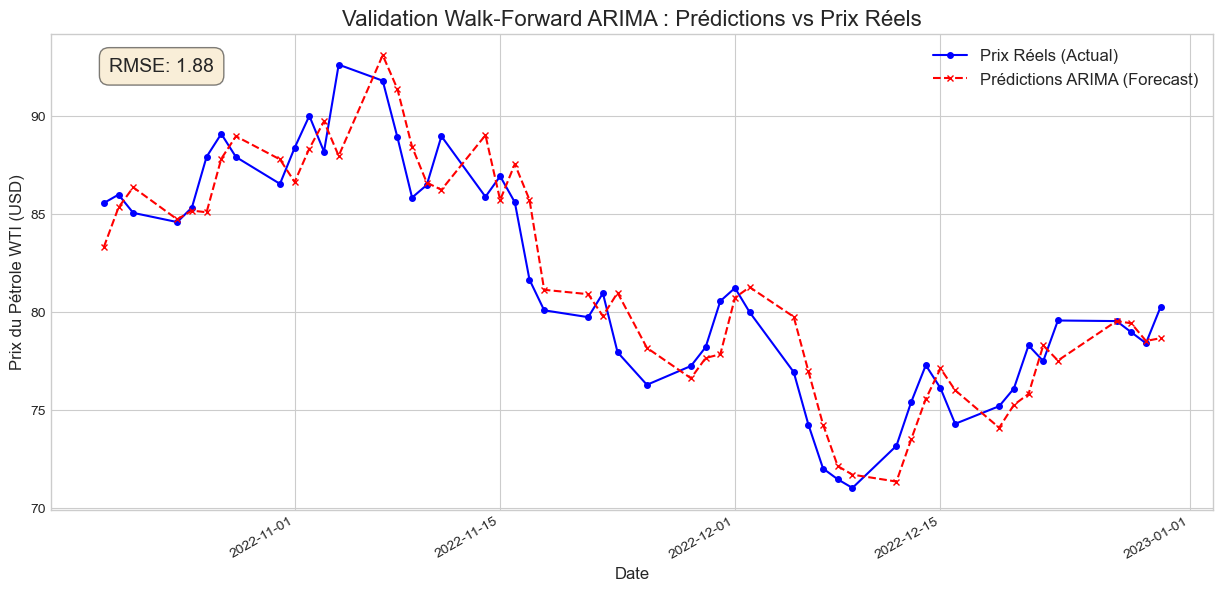

In [7]:
import warnings

warnings.filterwarnings("ignore")

# --- DATA LOADING ---
ticker_symbol = "CL=F"
start_date = "2022-01-01"
end_date = "2022-12-31"
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)

# --- THE DEFINITIVE FIX ---
# .squeeze() converts a single-column DataFrame into a 1D Series.
# This ensures we are working with a 1D array from the very beginning.
close_prices = wti_data['Close'].squeeze().astype(float)


# --- TRAIN/TEST SPLIT (now guaranteed to be from a 1D Series) ---
train_size = int(len(close_prices) * 0.8)
train, test = close_prices.iloc[:train_size], close_prices.iloc[train_size:]

# --- WALK-FORWARD VALIDATION ---
history = train.copy()
predictions = []

for t in range(len(test)):
    # This will now receive a clean, 1-dimensional, numeric Series
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()

    forecast = model_fit.forecast()
    yhat = forecast.iloc[0]
    predictions.append(yhat)

    obs = test.iloc[t]

    # This concatenation will now work correctly
    new_obs_series = pd.Series([obs], index=[test.index[t]])
    history = pd.concat([history, new_obs_series])

# --- EVALUATION ---
arima_rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'ARIMA Walk-Forward RMSE: {arima_rmse:.2f}')


try:
    test, predictions, arima_rmse
except NameError:
    print("Génération de données d'exemple car les variables n'ont pas été trouvées en mémoire.")
    dummy_dates = pd.date_range(start="2022-10-19", periods=51, freq='B')
    dummy_actuals = np.random.rand(51).cumsum() + 85
    arima_rmse = 1.88
    dummy_predictions = dummy_actuals + np.random.randn(51) * arima_rmse
    test = pd.Series(dummy_actuals, index=dummy_dates, name="Close")
    predictions = dummy_predictions
# --- Fin de la génération de données d'exemple ---


# Création du graphique
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 7))

# Tracer les prix réels de l'ensemble de test
plt.plot(test.index, test.values, label='Prix Réels (Actual)', color='blue', marker='o', markersize=4, linestyle='-')

# Tracer les prix prédits par le modèle
plt.plot(test.index, predictions, label='Prédictions ARIMA (Forecast)', color='red', marker='x', markersize=4, linestyle='--')

# Ajouter les titres et les étiquettes pour plus de clarté
plt.title('Validation Walk-Forward ARIMA : Prédictions vs Prix Réels', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Prix du Pétrole WTI (USD)', fontsize=12)
plt.legend(fontsize=12)

# Ajouter une boîte de texte avec la valeur du RMSE
# La boîte est placée dans le coin supérieur gauche du graphique.
plt.text(0.05, 0.95, f'RMSE: {arima_rmse:.2f}',
         transform=plt.gca().transAxes,
         fontsize=14,
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

# Assurer que les étiquettes de date ne se chevauchent pas
plt.gcf().autofmt_xdate()

# Afficher le graphique
plt.show()

In [4]:
warnings.filterwarnings("ignore")

# Chargement des données
ticker_symbol = "CL=F"
start_date = "2022-01-01"
end_date = "2022-12-31"
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)
close_prices = wti_data['Close'].squeeze().astype(float)

# Train/test split
train_size = int(len(close_prices) * 0.8)
train, test = close_prices.iloc[:train_size], close_prices.iloc[train_size:]

# Définition des plages pour p, d, q
p_values = range(0, 6)  # ex: 0 à 5
d_values = range(0, 3)  # ex: 0 à 2
q_values = range(0, 6)  # ex: 0 à 5

best_score, best_cfg = float("inf"), None

print("Recherche des paramètres ARIMA optimaux...")

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        # Créer et ajuster le modèle ARIMA sur l'ensemble train
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        
        # Prévision walk-forward sur test
        history = train.copy()
        predictions = []
        
        for t in range(len(test)):
            model = ARIMA(history, order=(p, d, q))
            model_fit = model.fit()
            forecast = model_fit.forecast()
            yhat = forecast.iloc[0]
            predictions.append(yhat)
            obs = test.iloc[t]
            history = pd.concat([history, pd.Series([obs], index=[test.index[t]])])
        
        # Calcul RMSE
        rmse = np.sqrt(mean_squared_error(test, predictions))
        
        if rmse < best_score:
            best_score, best_cfg = rmse, (p, d, q)
        
        print(f'ARIMA{(p,d,q)} RMSE={rmse:.3f}')
        
    except Exception as e:
        # Certains paramètres peuvent ne pas converger
        continue

print(f'\nMeilleur modèle ARIMA{best_cfg} avec RMSE={best_score:.3f}')

NameError: name 'warnings' is not defined

# Analyse des Résidus du Modèle ARIMA

L’analyse des résidus est une étape **cruciale** dans la modélisation ARIMA. Elle permet de vérifier si le modèle a bien capturé la structure des données et si les hypothèses statistiques sont respectées.

---

## Pourquoi analyser les résidus ?

- Vérifier que les résidus sont du **bruit blanc** (white noise) : moyenne nulle, variance constante, et absence d’autocorrélation.
- Confirmer que le modèle ne laisse pas d’information structurelle non modélisée.
- Valider les intervalles de confiance et les tests statistiques.

---

## Graphiques d’analyse des résidus

### 1. Histogramme et Q-Q plot

- **But :** Vérifier la normalité des résidus.
- **Importance :** Essentiel pour la validité des intervalles de confiance.
- **Fondement :** Les erreurs suivent une distribution normale centrée.

### 2. Trace plot (résidus dans le temps)

- **But :** Observer la stationnarité des résidus (moyenne et variance constantes).
- **Importance :** Conseillé pour détecter des tendances ou hétéroscédasticité.
- **Fondement :** Modèle adapté produit des résidus stationnaires.

### 3. Fonction d’Auto-Corrélation (ACF)

- **But :** Détecter des autocorrélations dans les résidus.
- **Importance :** Crucial : toute autocorrélation indique un modèle insuffisant.
- **Fondement :** Bruit blanc → autocorrélation nulle à tous les lags sauf lag 0.

### 4. Fonction d’Auto-Corrélation Partielle (PACF)

- **But :** Compléter l’ACF en mesurant l’autocorrélation directe à chaque lag.
- **Importance :** Utile pour identifier la structure des termes AR.
- **Fondement :** Aide à détecter l’ordre des composantes AR.

---

## Tableau résumé

| Graphique             | Objectif                         | Nécessité          | Fondement mathématique                       |
|-----------------------|---------------------------------|--------------------|---------------------------------------------|
| Histogramme / Q-Q plot | Vérifier la normalité des résidus | Fortement conseillé | Hypothèse d’erreurs normales                |
| Trace plot            | Vérifier stationnarité des résidus | Conseillé          | Stationnarité faible                         |
| ACF                   | Vérifier absence d’autocorrélation | Crucial            | Bruit blanc → autocorrélation nulle         |
| PACF                  | Complément ACF pour structure AR  | Utile              | Identification des ordres AR dans le modèle |

---

## Conclusion

L’analyse des résidus est indispensable pour s’assurer que le modèle ARIMA est bien adapté aux données. Sans cette validation, les prévisions peuvent être erronées et trompeuses.

---



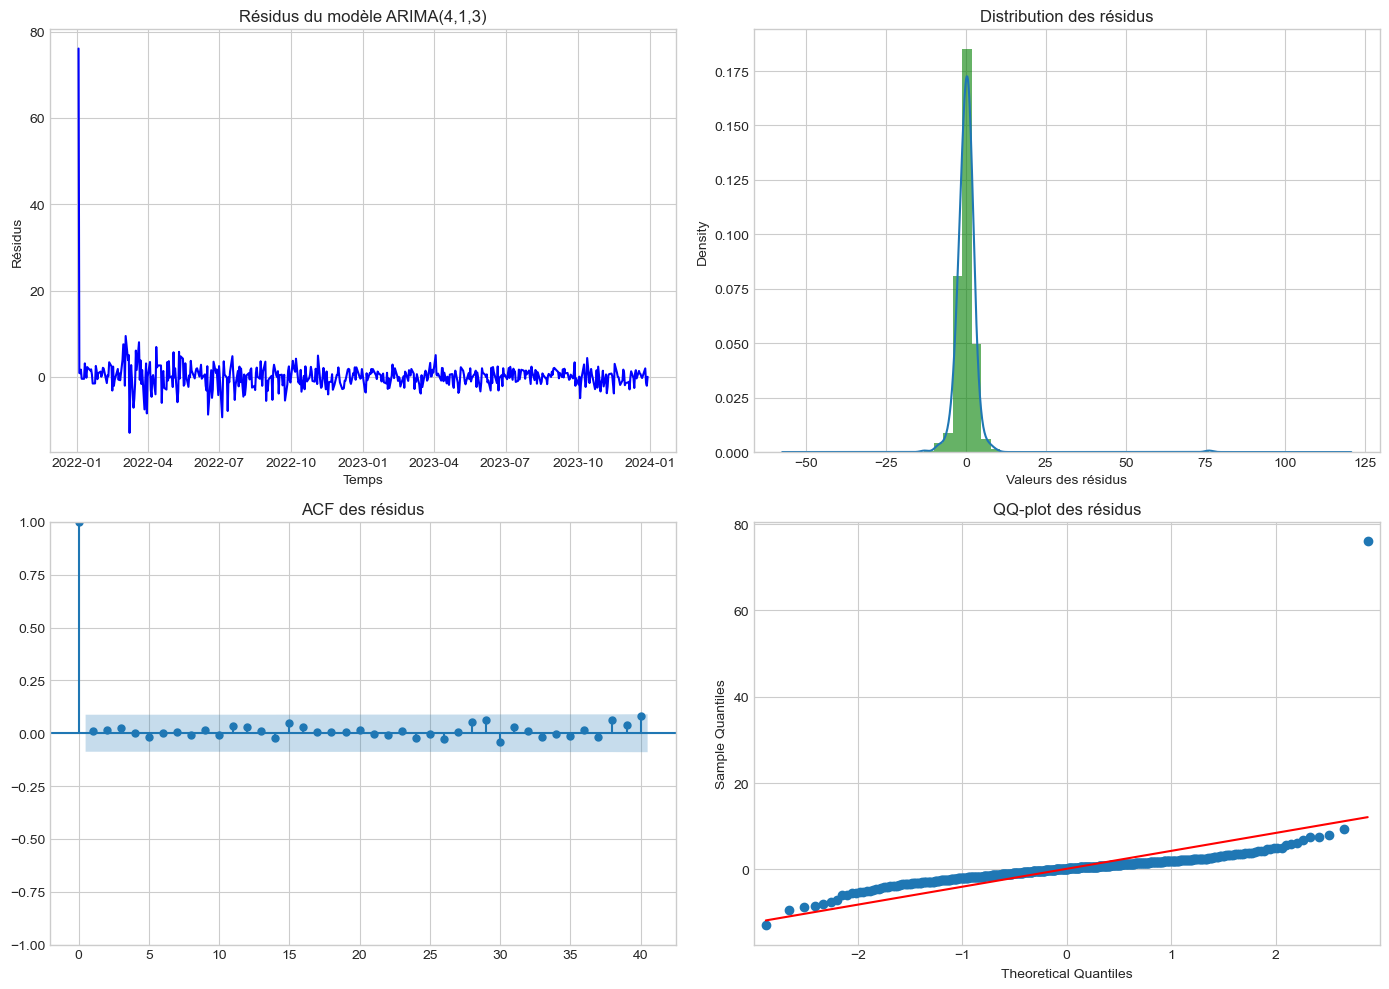

    lb_stat  lb_pvalue
5  0.617035    0.98721


In [13]:
# Chargement des données
ticker_symbol = "CL=F"
start_date = "2022-01-01"
end_date = "2023-12-31"
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)
close_prices = wti_data['Close'].squeeze().astype(float)

# Entraîner le modèle sur toutes les données (train + test)
model = ARIMA(close_prices, order=(4, 1, 3))
model_fit = model.fit()

# Résidus
residuals = model_fit.resid

# Création de la figure avec 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 1. Graphique des résidus
axs[0, 0].plot(residuals, color='blue')
axs[0, 0].set_title("Résidus du modèle ARIMA(4,1,3)")
axs[0, 0].set_xlabel("Temps")
axs[0, 0].set_ylabel("Résidus")

# 2. Histogramme + KDE des résidus
residuals.plot(kind='hist', bins=30, density=True, alpha=0.6, color='g', ax=axs[0, 1])
residuals.plot(kind='kde', ax=axs[0, 1])
axs[0, 1].set_title("Distribution des résidus")
axs[0, 1].set_xlabel("Valeurs des résidus")

# 3. ACF des résidus
plot_acf(residuals, lags=40, ax=axs[1, 0])
axs[1, 0].set_title("ACF des résidus")

# 4. QQ-plot des résidus
sm.qqplot(residuals, line='s', ax=axs[1, 1])
axs[1, 1].set_title("QQ-plot des résidus")

plt.tight_layout()
plt.show()

# 5. Test de Ljung-Box
ljung_box_result = sm.stats.acorr_ljungbox(residuals, lags=[5], return_df=True)
print(ljung_box_result)

# Interprétation Visuelle du QQ Plot

Le QQ plot (Quantile-Quantile plot) est un outil graphique utilisé pour vérifier si un ensemble de données suit une distribution théorique, souvent la distribution normale.

---

## But du QQ plot

- Comparer la distribution des résidus d’un modèle à une distribution normale.
- Vérifier l’hypothèse de normalité des erreurs, essentielle pour certains tests statistiques et pour valider un modèle ARIMA.

---

## Comment interpréter un QQ plot visuellement

| Observation visuelle           | Interprétation                            |
|-------------------------------|------------------------------------------|
| Points alignés sur la ligne diagonale (45°)    | Résidus suivent une distribution normale (bon modèle)           |
| Points formant une courbe en “S”    | Présence d’asymétrie (skewness) dans les résidus    |
| Points qui s’écartent surtout aux extrémités (queues)    | Présence d’outliers ou queues lourdes (kurtosis élevée)   |
| Points formant une courbe convexe ou concave        | Résidus plus aplatis ou plus pointus que la normale   |

---

## Pourquoi c’est important

- La normalité des résidus est une hypothèse clé pour la validité des intervalles de confiance et des tests statistiques appliqués au modèle.
- Des résidus non normaux peuvent indiquer un modèle mal ajusté ou la nécessité de transformations supplémentaires.

---

## En résumé

Un bon modèle ARIMA présente des résidus qui, sur le QQ plot, s’alignent étroitement sur la diagonale. Tout écart important suggère que le modèle pourrait ne pas bien capturer la dynamique sous-jacente des données.


Lors de l’ajustement des modèles ARIMA, on a observé que passer de `d=3` à `d=1` entraînait des valeurs de RMSE proches, suggérant une performance similaire en termes d’erreur de prédiction. Cependant, cette similarité ne garantit pas que les modèles capturent aussi bien la dynamique des données. En effet, le degré de différenciation `d` influence la stationnarité et la structure des résidus. C’est pourquoi il est crucial d’effectuer systématiquement des tests sur les résidus, comme le test de Ljung-Box, à chaque étape d’optimisation afin de s’assurer que le modèle retenu n’a pas laissé de corrélations non expliquées et est statistiquement valide.


# RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define features (X) and target (y)
features = ['MA_50', 'MA_200', 'Price_Change', 'Volatility']
target = 'Close'

X = wti_data[features]
y = wti_data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# For Random Forest model
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
print(f"Random Forest Model RMSE: {rf_rmse}")

# Visualize the predictions against the actual prices
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Price')
plt.plot(y_test.index, rf_predictions, label='Random Forest Predictions', linestyle='--')
plt.title('WTI Crude Oil Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Get the last row of your data to make a prediction for the next day
last_data_point = wti_data[features].iloc[-1:].values

# Predict the next day's price
future_price = rf_model.predict(last_data_point)
print(f"Predicted WTI Crude Oil Price for the next day: {future_price[0]}")